In [1]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras

import optuna

Function Trials:

In [2]:
import bayesflow as bf
from dmc import DMC

with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).


In [3]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500,
    contamination_probability=.05,
    num_obs=500
)

Experiment Function:

In [4]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "t0", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)

In [ ]:
file_path = '../data/data_offline_training/data_offline_training500trials.pickle'

train_data = simulator.sample(50000)

with open(file_path, 'wb') as file:
    pickle.dump(train_data, file)


## Load Training and Validation Data

In [17]:
training_file_path = '../data/data_offline_training/data_offline_training.pickle'

with open(training_file_path, 'rb') as file:
    train_data = pickle.load(file)

    
val_file_path = '../data/data_offline_training/data_offline_validation.pickle'

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)


In [63]:
def weighted_metric_sum(metrics_table, weight_recovery=1, weight_pc=1, weight_sbc=1):
    
    # recode posterior contraction
    metrics_table.iloc[1,:]=1-metrics_table.iloc[1,:]

    # compute means across parameters
    metrics_means=metrics_table.mean(axis=1)

    # decide on weights for each metric (Recovery, Posterior Contraction, SBC)
    metrics_weights=np.array([weight_recovery, weight_pc, weight_sbc])

    # compute weighted sum
    weighted_sum=np.dot(metrics_means, metrics_weights)
    
    return weighted_sum

In [64]:
### define objective function

def objective(epochs=1):

    # Optimize hyperparameters
    # dropout = trial.suggest_float("dropout", 0.01, 0.5)
    # initial_learning_rate = trial.suggest_float("lr", 1e-4, 1e-3) 
    
    dropout = 0.1
    initial_learning_rate = 5e-4
    batch_size=128
    
    # Create inference net
    
    inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=dropout)))

    # inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

    summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=2, dropout=0.1)
    
    
    workflow = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        initial_learning_rate=initial_learning_rate,
        inference_network=inference_net,
        summary_network=summary_net,
        # checkpoint_filepath='../checkpoints',
        # checkpoint_name= "simons_crazy_net3",
        inference_variables=["A", "tau", "mu_c", "t0", "b"])
    
    history = workflow.fit_offline(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data)
    
    metrics_table=workflow.compute_default_diagnostics(test_data=val_data)

    # compute weighted sum
    weighted_sum=weighted_metric_sum(metrics_table)
    
    # loss=np.mean(history.history["val_loss"][-5:])
        
    return weighted_sum

objective_test=objective()



INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 6.4618 - loss/inference_loss: 6.4618

KeyboardInterrupt: 

In [ ]:
objective_test

0.8598938856409903

In [ ]:

def objective(trial, epochs=50):

    # Optimize hyperparameters
    dropout = trial.suggest_float("dropout", 0.01, 0.3)
    initial_learning_rate = trial.suggest_float("lr", 1e-4, 1e-3) 
    num_seeds=trial.suggest_int("num_seeds", 1, 4)
    depth=trial.suggest_int("depth", 5, 10)
    
    batch_size=128
    
    # Create inference net 
    inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=dropout)), depth=depth)

    summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=num_seeds, dropout=dropout)
    
    
    workflow = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        initial_learning_rate=initial_learning_rate,
        inference_network=inference_net,
        summary_network=summary_net,
        # checkpoint_filepath='../checkpoints',
        # checkpoint_name= "simons_crazy_net3",
        inference_variables=["A", "tau", "mu_c", "t0", "b"])
    
    history = workflow.fit_offline(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data, verbose=0)
    
    metrics_table=workflow.compute_default_diagnostics(test_data=val_data)

    # compute weighted sum
    weighted_sum=weighted_metric_sum(metrics_table)
    
    # loss=np.mean(history.history["val_loss"][-5:])
        
    return weighted_sum

In [73]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=40)

[I 2025-04-02 18:57:01,588] A new study created in memory with name: no-name-3df42576-5ff5-4a51-863e-3aa99e7bac20
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2025-04-02 19:20:41,821] Trial 0 finished with value: 0.3671495569967654 and parameters: {'dropout': 0.14897769957851867, 'lr': 0.000869910397329933, 'num_seeds': 4, 'depth': 8}. Best is trial 0 with value: 0.3671495569967654.
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2025-04-02 19:39:47,068] Trial 1 finished with value: 0.4268942741742283 and parameters: {'dropout': 0.21885899188349522, 'lr': 0.0008756214916702613, 'num_seeds': 2, 'depth': 5}. Best is trial 0 with value: 0.3671495569967654.
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2025-04-02 20:04:12,895] Trial 2 finished with value: 0.3311017336289652 and parameters: {'dropout': 0.2847927838

In [74]:
trial = study.best_trial
print("Validation loss: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Validation loss: 0.26759983484342403
Best hyperparameters: {'dropout': 0.011529281588535391, 'lr': 0.0008293769610382236, 'num_seeds': 2, 'depth': 7}


In [ ]:
trial.params["dropout"]

{'dropout': 0.011529281588535391,
 'lr': 0.0008293769610382236,
 'num_seeds': 2,
 'depth': 7}

In [79]:
inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=trial.params["dropout"])), depth=trial.params["depth"])

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=trial.params["num_seeds"], dropout=trial.params["dropout"])

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=trial.params["lr"],
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../checkpoints',
    checkpoint_name= "optuna_run1",
    inference_variables=["A", "tau", "mu_c", "t0", "b"]
)

In [82]:
batch_size=128

history = workflow.fit_offline(train_data, epochs=50, batch_size=batch_size, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/50


391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: -0.3378 - loss/inference_loss: -0.3378 - val_loss: -0.1474 - val_loss/inference_loss: -0.1474
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - loss: -0.3388 - loss/inference_loss: -0.3388 - val_loss: -0.2861 - val_loss/inference_loss: -0.2861
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: -0.3344 - loss/inference_loss: -0.3344 - val_loss: -0.1439 - val_loss/inference_loss: -0.1439
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: -0.3461 - loss/inference_loss: -0.3461 - val_loss: -0.3219 - val_loss/inference_loss: -0.3219
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - loss: -0.3415 - loss/inference_loss: -0.3415 - val_loss: 0.0487 - val_loss/inference_loss: 0.0487
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: -0.3410 - loss/inference_loss: -0.3410 - val_loss: -0.4771 - val_loss/inference_loss: -0.4771
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - loss: -0.3321 - loss/

INFO:bayesflow:Training is now finished.
            You can find the trained approximator at '../checkpoints/optuna_run1.optuna_run1.keras'.
            To load it, use approximator = keras.saving.load_model(...).


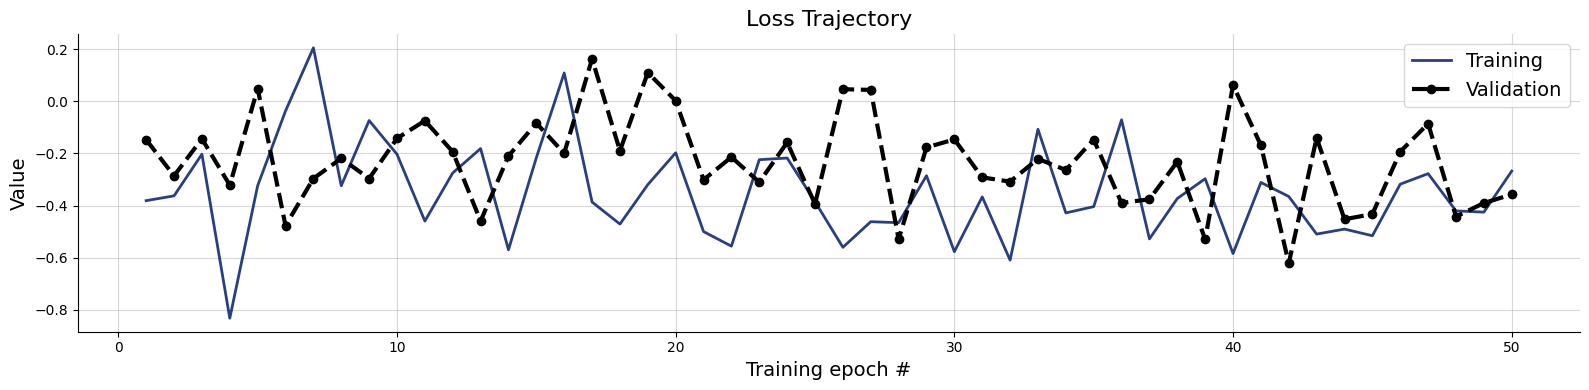

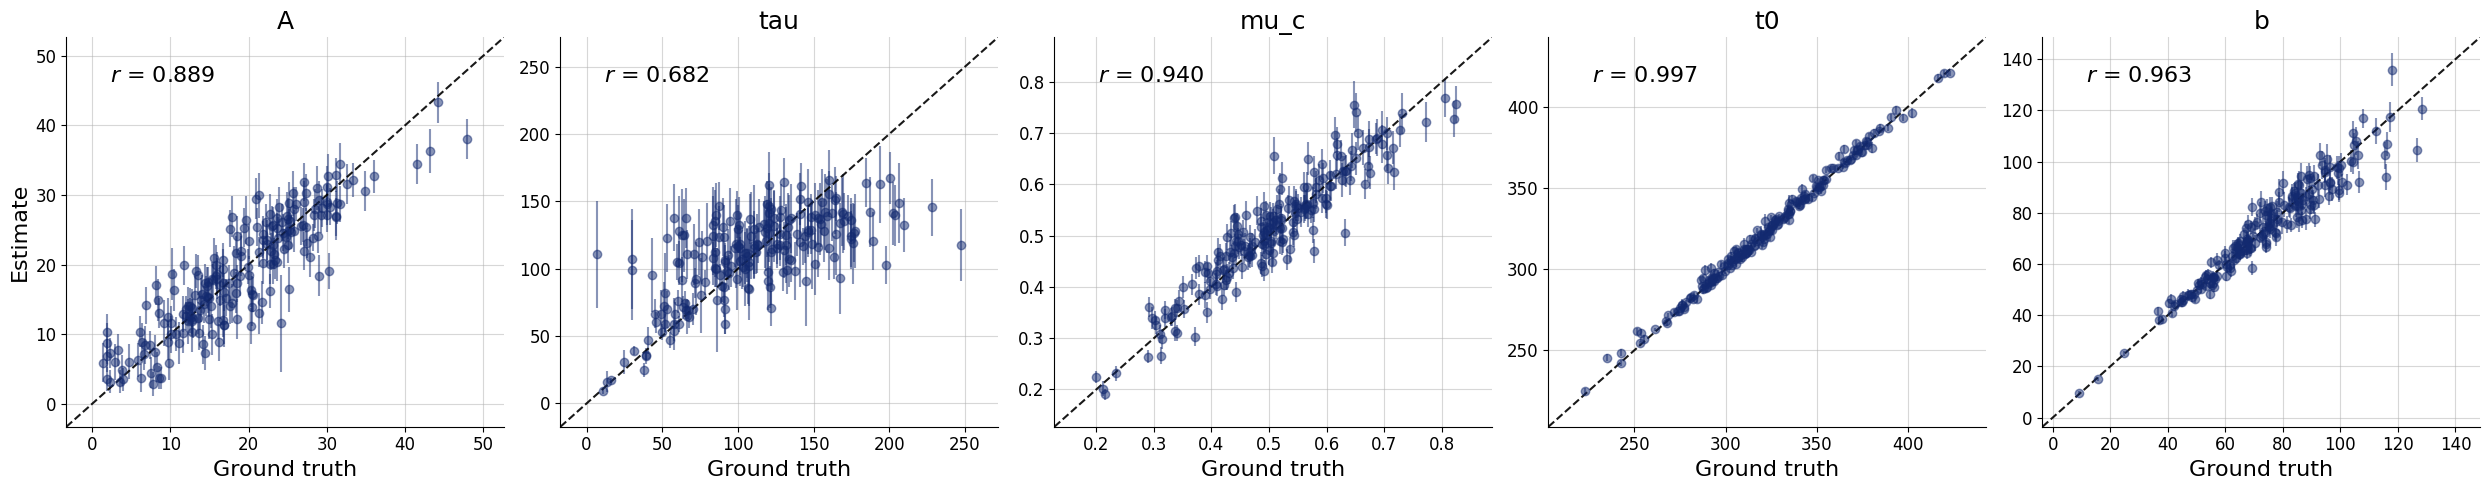

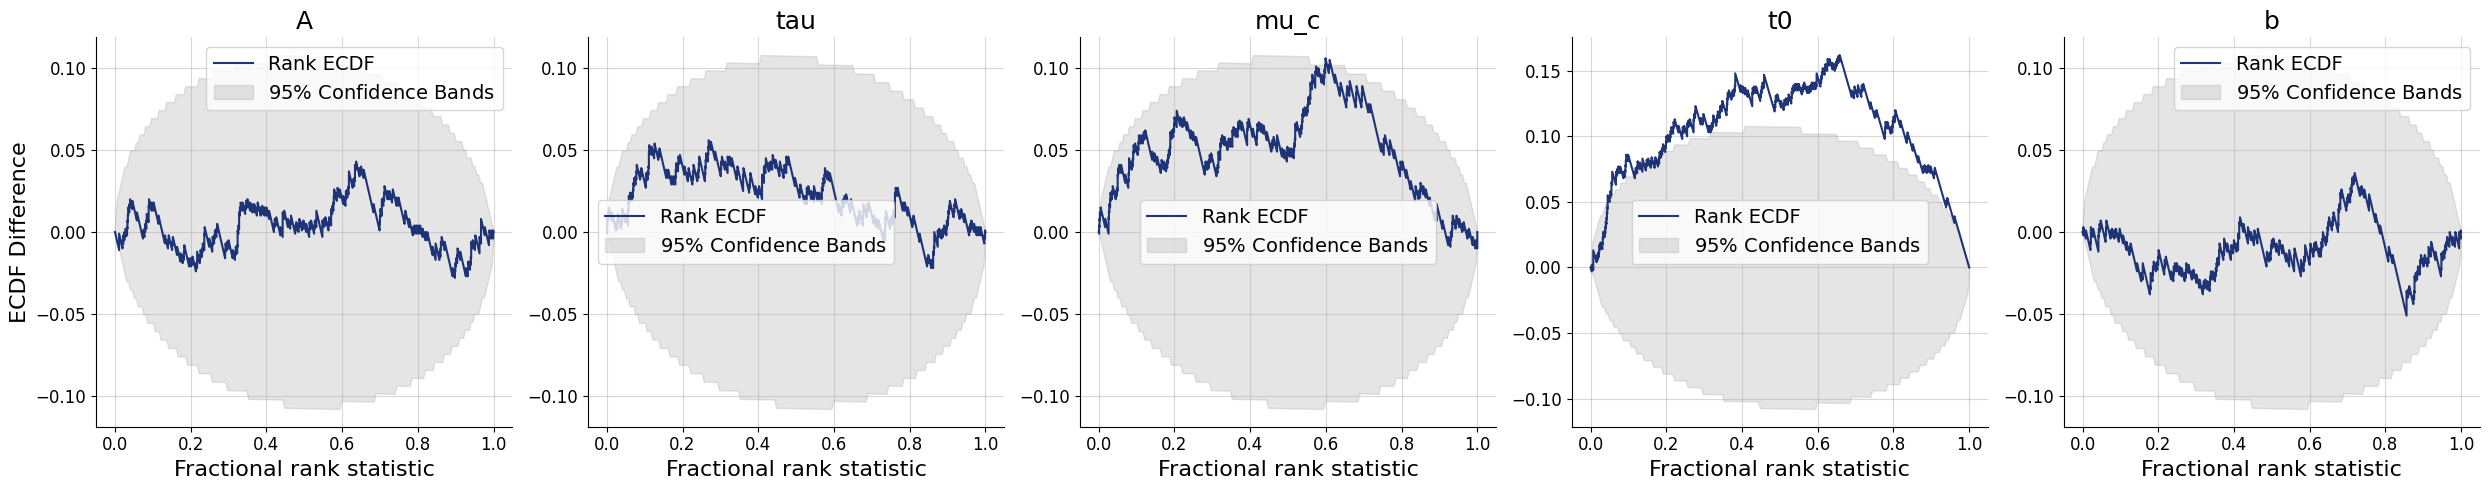

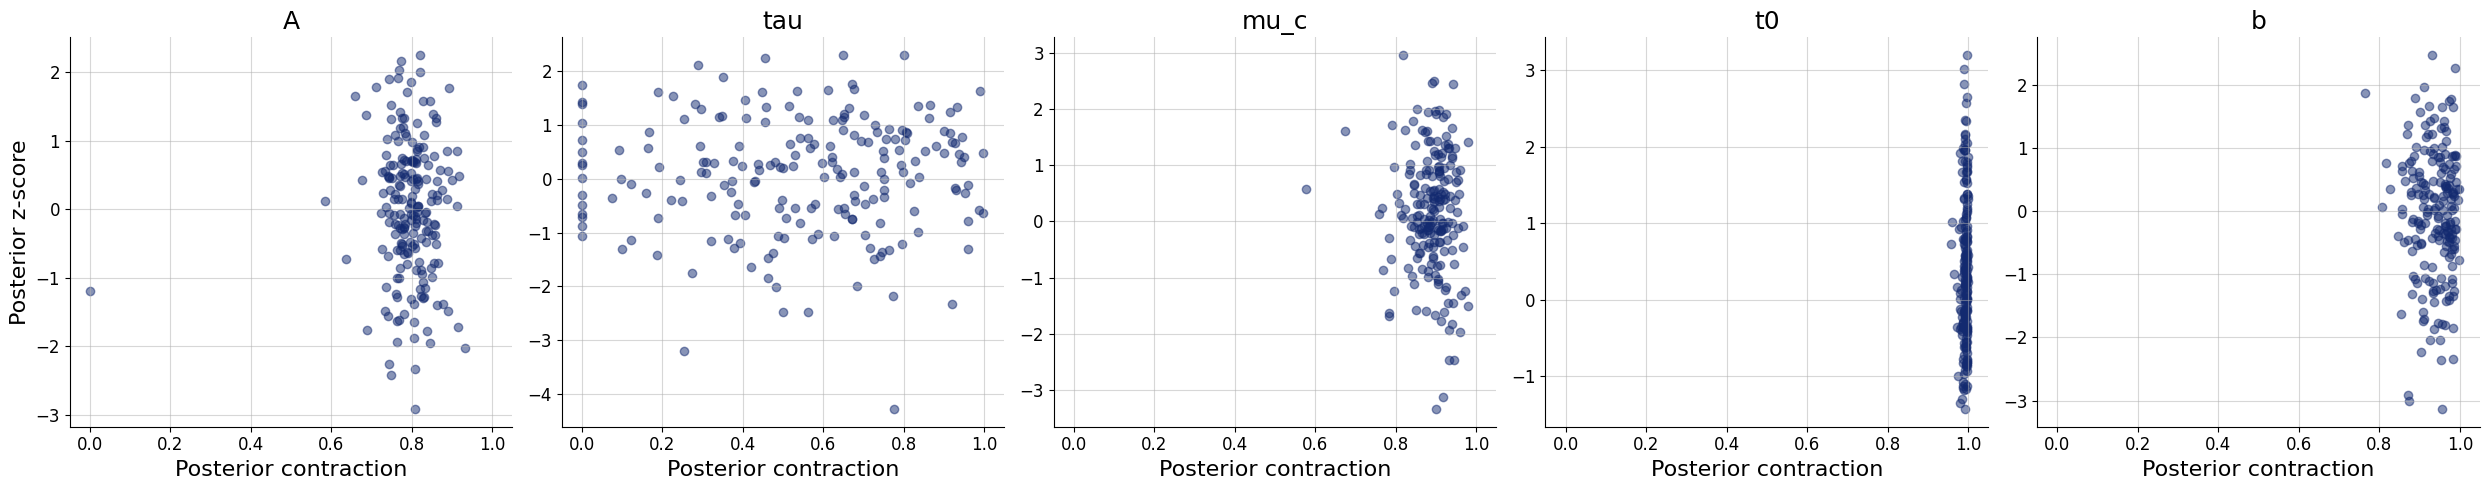

In [83]:
figs = workflow.plot_default_diagnostics(test_data=val_data, calibration_ecdf_kwargs=dict(difference=True))